In [1]:
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

/home/claserken/mambaforge/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "google/ddpm-celebahq-256"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id).to(device)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference

diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


In [3]:
# image = ddpm()

In [4]:
# image[0][0]

In [5]:
# def load_image(image_path):
#     transform = transforms.ToTensor()
#     image = Image.open(image_path)
#     image = transform(image) * 2 - 1
#     return image.to(device)

In [6]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(image_path)
    image = transform(image)
    return image.to(device)

In [7]:
train_img = load_image('../data/examples/celeba_hq_256/10001.jpg')

In [8]:
scheduler = ddpm.scheduler

In [9]:
def inject_noise(image, timestep, scheduler):
    noise = torch.randn_like(image, device=device)
    noisy_image = scheduler.add_noise(image, noise, timestep)
    return noisy_image, noise

In [10]:
def flatten(arr):
    flattened_arr = []
    for elem in arr:
        if isinstance(elem, list):
            flattened_arr.extend(elem)
        else:
            flattened_arr.append(elem)
    return flattened_arr

def show_image(image_tensors, rows=None, cols=None):
    if not isinstance(image_tensors, list):
        image_tensors = [image_tensors]
    
    image_tensors = [list(image_tensor) if image_tensor.dim() == 4 else image_tensor for image_tensor in image_tensors]
    image_tensors = flatten(image_tensors)
    num_images = len(image_tensors)
    
    if rows is None and cols is None:
        rows = int(math.sqrt(num_images))
        cols = int(math.ceil(num_images / rows))
    elif rows is None:
        rows = int(math.ceil(num_images / cols))
    elif cols is None:
        cols = int(math.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    
    # Flatten axes if it's a 2D array, otherwise make it a list
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flat
    
    for i, ax in enumerate(axes):
        if i < num_images:
            img_permuted = (image_tensors[i].squeeze().permute(1, 2, 0) + 1) / 2
            img_np = img_permuted.cpu().numpy()
            ax.imshow(img_np)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

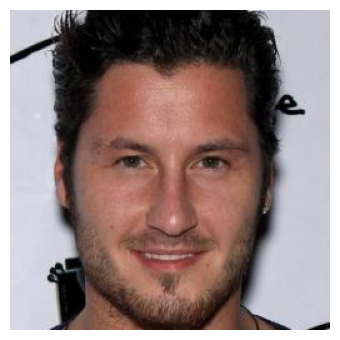

In [11]:
show_image(train_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3908739..2.1442468].


Noisy Image at Timestep 250:


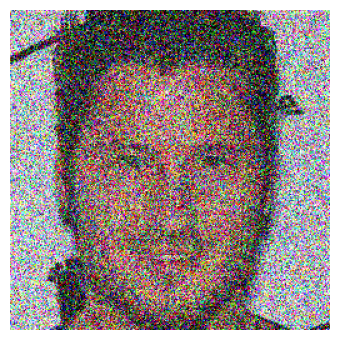

In [12]:
# Inject noise at a specific timestep
timestep = torch.tensor(250, device=device)
noisy_image, noise = inject_noise(train_img, timestep, scheduler)
print(f"Noisy Image at Timestep {timestep}:")
show_image(noisy_image)

In [13]:
noisy_image.max()

tensor(4.2418, device='cuda:0')

In [14]:
from diffusers import UNet2DModel
pretrained_model = UNet2DModel.from_pretrained('/home/claserken/Developer/dataunlearning/checkpoints/celeb/deletion/2024-08-30_04-04-45/checkpoint-1000/unet').to('cuda')

In [15]:
def denoise(noisy_image, timestep, scheduler, model, batch_size=1):
    # Create a batch of images by repeating the input image `batch_size` times
    model_input = noisy_image.repeat(batch_size, 1, 1, 1)
    with torch.no_grad():
        for t in tqdm(reversed(range(timestep + 1))):
            # Pass the entire batch through the model
            model_output = model(model_input, t)["sample"]
            # Update the model_input for the next step with the entire batch
            model_input = scheduler.step(model_output, t, model_input)["prev_sample"]
    return model_input

In [16]:
# def generate_guidance(timesteps, scheduler, model, clean_img, guidance_level: float = 0, batch_size=1):
#     # Create a batch of images by repeating the input image `batch_size` times
#     model_input = noisy_image.repeat(batch_size, 1, 1, 1)
#     with torch.no_grad():
#         for t in tqdm(reversed(timesteps)):
#             # Pass the entire batch through the model
#             model_output = model.unet(model_input, t)["sample"]
#             # Update the model_input for the next step with the entire batch
#             model_input = scheduler.step(model_output, t, model_input)["prev_sample"]
#     return model_input

In [17]:
# Denoise the image
denoised_image = denoise(noisy_image, timestep, scheduler, ddpm.unet, batch_size=8) # model can be either pretrained_model or ddpm.unet
# print("Denoised Image:")
# show_image(denoised_image)

1000it [03:39,  4.56it/s]


In [18]:
denoised_image.min()

tensor(-1., device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


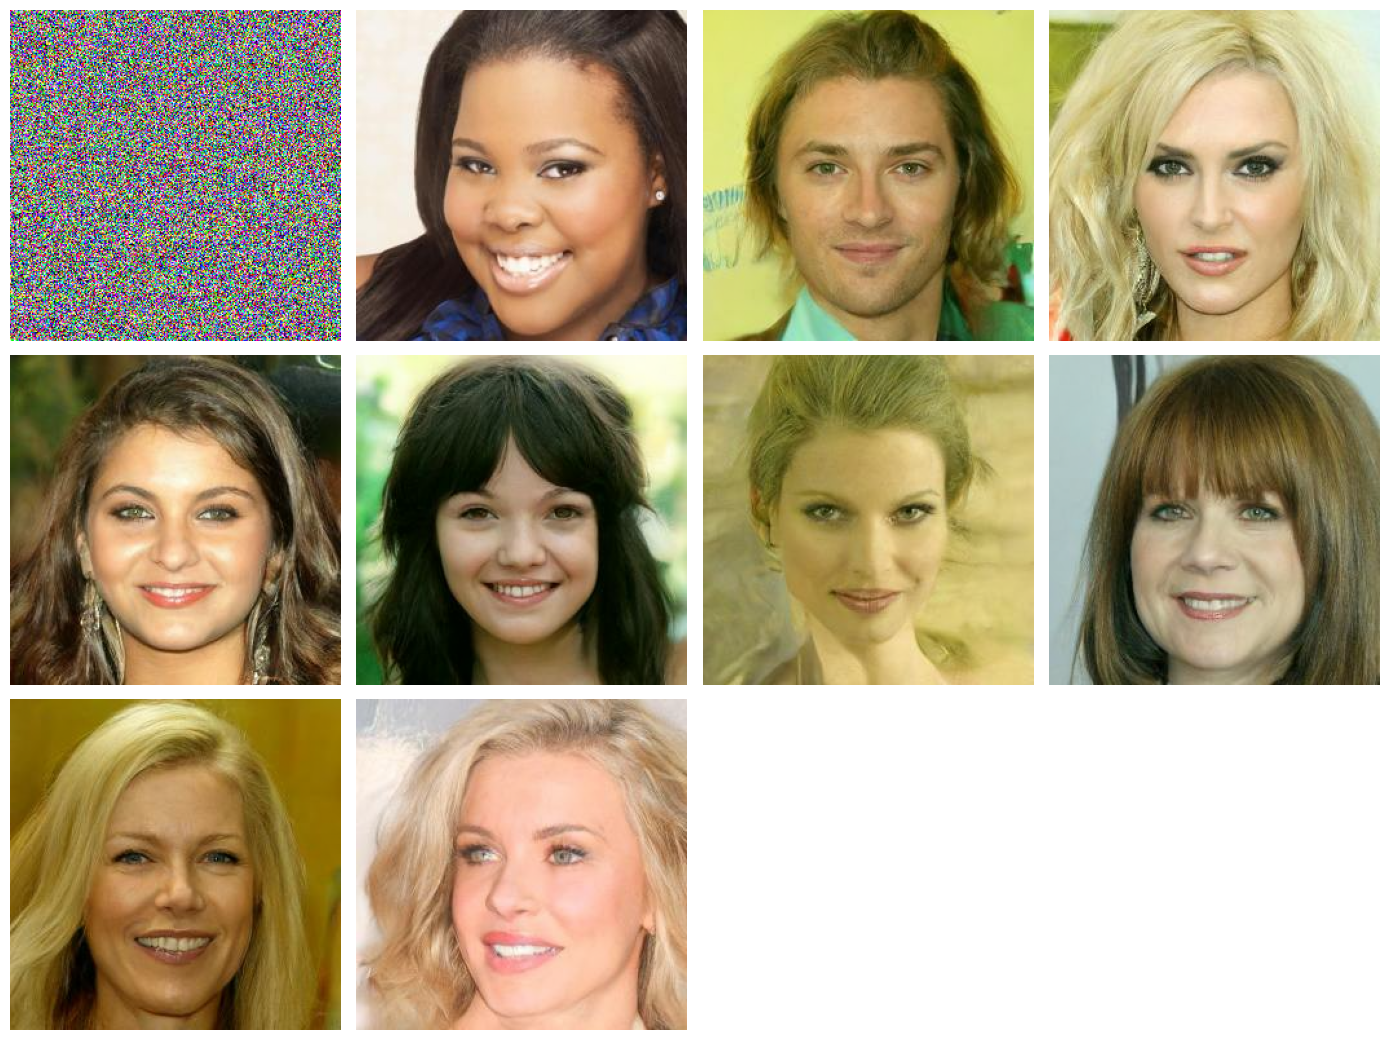

In [19]:
show_image([noisy_image, train_img, denoised_image])